# Minute Resolution Part of Project

# Analyzing Data from 2017-2018

In [1]:
from myPyPackages import myData, myDates, myStats, mySignal, myPlots # custom modules.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd

from scipy import stats as sp_stats
from scipy.signal import welch
import scipy.interpolate as interp

import glob
from PIL import Image
import seaborn as sb

from scipy import signal

In [2]:
# Filepath to save plots

FOLDER = '../Figures/Minute/'
heatmap_folder = FOLDER + "HeatMaps/"
corr_folder = FOLDER + "Correlations/"
uvic_folder = FOLDER + "UVic/"
craigflower_folder = FOLDER + 'Craigflower/'
monterey_folder = FOLDER + 'Monterey/'
shawnigan_folder = FOLDER + 'ShawniganLake/'
cumberland_folder = FOLDER + 'Cumberland/'
station_folders = [uvic_folder, monterey_folder, craigflower_folder, 
                    shawnigan_folder, cumberland_folder]

In [3]:
# Station Names
station_names = ['UVicSci', 'Monterey', 'Craigflower', 'ShawniganLake','Cumberland']
label_names = ['UVic', 'Monterey', 'Craigflower', 'ShawniganLake','Cumberland']
abbr_names = ['UVic', 'Mon', 'Craig', 'SL', 'Cumb']

# Other Parameters. All minute data sets share these parameters.
START = 736330.0     # start date 
END = 738733.99931   # end date
N = 3461760          # number of data points
sample_f = 1/60

# Reading in Station info
station_info = [myData.getStationInfo(station) for station in station_names]
UVicSci_info, Monterey_info, Craigflower_info, ShawniganLake_info, Cumberland_info = station_info

dtype = 'min'
summer_start = myDates.DateStrtoNum('01/06/2017', dtype = dtype)
summer_end = myDates.DateStrtoNum('30/09/2017, 23:59', dtype=dtype)
winter_start = myDates.DateStrtoNum('01/11/2017', dtype = dtype)
winter_end = myDates.DateStrtoNum('28/02/2018, 23:59', dtype=dtype)

# Reading in Minute data for all stations
data = [myData.readMinuteData(station) for station in station_names]
data_summer = [myDates.getRange(d, summer_start, summer_end) for d in data]
data_winter = [myDates.getRange(d, winter_start, winter_end) for d in data]

## Checking for Nan values

In [4]:
def checkNans(data):
    tmp = []
    for d in data:
        tmp.append(d.drop('times', axis=1).isna().any())

    tempNans = np.dstack(tmp)[0][0]
    pressNans = np.dstack(tmp)[0][1]

    print("Nans in Temps? ->  {}.".format(True in tempNans))
    print("Nans in Press? ->  {}.".format(True in pressNans))

In [5]:
print("For Summer")
checkNans(data_summer)
print()

print("For Winter")
checkNans(data_winter)

For Summer
Nans in Temps? ->  False.
Nans in Press? ->  False.

For Winter
Nans in Temps? ->  False.
Nans in Press? ->  False.


##  Getting Basic Statistics

In [6]:
# print("***For Summer***")
# myData.getBasicStats(data_summer, station_names)

# print("***For Winter***")
# myData.getBasicStats(data_winter, station_names)

## Plotting Time Series and Power Spectral Densities

In [7]:
def plotTemp_withPSD(index, names):
    fig, axes = plt.subplots(3, 2, figsize=(20, 12))
    axes = np.hstack(axes)
    colors = cm.rainbow(np.linspace(0, 1, 4))

    i = index
    fs = 16 # fontsize
    fig.suptitle(names[i] + ': Temperature Time Series, PSD and Variance-Perserving PSD',  y=.97, fontsize=fs + 4)


    # Plotting time series stuff
    xlabel = 'Time [DD/MM/YYYY]'
    ylabel = "Temperature [$^{\circ} C$]"

    timeSeries_title = '{} Time Series'
    PSD_title = '{} Power Spectral Density'
    varPer_title = '{} Variance-Perserving PSD'

    axs = axes[0]
    ticks = np.linspace(summer_start, summer_end, 6)
    tickLabels =  [myDates.DateNumtoStr(t, 'min') for t in ticks]
    axs.plot(data_summer[i].times, data_summer[i].temperature, color = colors[0])
    axs.set_title(timeSeries_title.format("Summer"), fontsize= fs+2)
    axs.set_xticks(ticks)
    axs.set_xticklabels(tickLabels)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=15)
    axs.grid()
    axs.tick_params(labelsize=fs-2)


    axs = axes[1]
    ticks = np.linspace(winter_start, winter_end, 6)
    tickLabels =  [myDates.DateNumtoStr(t, 'min') for t in ticks]
    axs.plot(data_winter[i].times, data_winter[i].temperature, color = colors[1])
    axs.set_title(timeSeries_title.format("Winter"), fontsize= fs+4)
    axs.set_xticks(ticks)
    axs.set_xticklabels(tickLabels)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=15)
    axs.grid()
    axs.tick_params(labelsize=fs-2)


    # Plotting Spectral Stuff

    xlabel = 'Frequency [$cpd$]'
    ylabel = "$\Gamma$ [$^\circ C^2/cpd$]"

    axs = axes[2]
    NS, NFFT = mySignal.GetNS_NFFT(data_summer[i].temperature)
    ff_s, Pxx_s = welch(data_summer[i].temperature, sample_f, nperseg=NFFT, noverlap=NFFT//2) # defaults to wanning window.
    axs.loglog(ff_s, Pxx_s, color=colors[2])
    axs.set_title(PSD_title.format('Summer'), fontsize=fs)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs)
    axs.grid()
    axs.tick_params(labelsize=fs-2)


    axs = axes[3]
    NS, NFFT = mySignal.GetNS_NFFT(data_winter[i].temperature)
    ff_w, Pxx_w = welch(data_winter[i].temperature, sample_f, nperseg=NFFT, noverlap=NFFT//2) # defaults to wanning window.
    axs.loglog(ff_w, Pxx_w, color=colors[3])
    axs.set_title(PSD_title.format('Winter'), fontsize=fs)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=10)
    axs.grid()
    axs.tick_params(labelsize=fs-2)

    # Variance perserving PSD
    # xlabel = 'Frequency [$cpd$]'
    ylabel = "$f\ \Gamma(F)$ [$^\circ C^2$]"

    axs = axes[4]
    axs.semilogx(ff_s, Pxx_s*ff_s, color=colors[3])
    axs.set_title(varPer_title.format('Summer'), fontsize=fs)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=10)
    axs.grid()
    axs.tick_params(labelsize=fs-2)

    axs = axes[5]
    axs.semilogx(ff_w, Pxx_w*ff_w, color=colors[3])
    axs.set_title(varPer_title.format('Winter'), fontsize=fs)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=10)
    axs.grid()
    axs.tick_params(labelsize=fs-2)

    plt.subplots_adjust(hspace=0.5, wspace=0.25, top=0.9)

def plotPress_withPSD(index, names):
    fig, axes = plt.subplots(3, 2, figsize=(20, 12))
    
    axes = np.hstack(axes)
    colors = cm.rainbow(np.linspace(0, 1, 4))

    i = index
    fs = 16 # fontsize
    fig.suptitle(names[i] + ': Pressure Time Series, PSD and Variance-Perserving PSD',  y=.97, fontsize=fs + 2)

    timeSeries_title = '{} Time Series'
    PSD_title = '{} Power Spectral Density'
    varPer_title = '{} Variance-Perserving PSD'

    # Plotting time Series stuff
    xlabel = 'Time [DD/MM/YYYY]'
    ylabel = "Pressure [$hPa$]"

    axs = axes[0]
    ticks = np.linspace(summer_start, summer_end, 6)
    tickLabels =  [myDates.DateNumtoStr(t, 'min') for t in ticks]
    axs.plot(data_summer[i].times, data_summer[i].pressure, color = colors[0])
    axs.set_title(timeSeries_title.format("Summer"), fontsize= fs+2)
    axs.set_xticks(ticks)
    axs.set_xticklabels(tickLabels)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=10)
    axs.grid()
    axs.tick_params(labelsize=fs-2)


    axs = axes[1]
    ticks = np.linspace(winter_start, winter_end, 6)
    tickLabels =  [myDates.DateNumtoStr(t, 'min') for t in ticks]
    axs.plot(data_winter[i].times, data_winter[i].pressure, color = colors[1])
    axs.set_title(timeSeries_title.format("Winter"), fontsize= fs+2)
    axs.set_xticks(ticks)
    axs.set_xticklabels(tickLabels)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=10)
    axs.grid()
    axs.tick_params(labelsize=fs-2)


    # Plotting Spectral Stuff

    xlabel = 'Frequency [$cpd$]'
    ylabel = "PSD [$hPa^2/cpd$]"

    axs = axes[2]
    NS, NFFT = mySignal.GetNS_NFFT(data_summer[i].pressure)
    ff_s, Pxx_s = welch(data_summer[i].temperature, sample_f, nperseg=NFFT, noverlap=NFFT//2) # defaults to wanning window.
    axs.loglog(ff_s, Pxx_s, color=colors[2])
    axs.set_title(PSD_title.format('Summer'), fontsize=fs+2)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs)
    axs.grid()
    axs.tick_params(labelsize=fs-2)


    axs = axes[3]
    NS, NFFT = mySignal.GetNS_NFFT(data_winter[i].pressure)
    ff_w, Pxx_w = welch(data_winter[i].pressure, sample_f, nperseg=NFFT, noverlap=NFFT//2) # defaults to wanning window.
    axs.loglog(ff_w, Pxx_w, color=colors[3])
    axs.set_title(PSD_title.format('Winter'), fontsize=fs+2)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=10)
    axs.grid()
    axs.tick_params(labelsize=fs-2)

    # Variance perserving PSD
    ylabel = "$f\ \Gamma(F)$ [$hPa^2$]"

    axs = axes[4]
    axs.semilogx(ff_s, Pxx_s*ff_s, color=colors[3])
    axs.set_title(varPer_title.format('Summer'), fontsize=fs+2)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=10)
    axs.grid()
    axs.tick_params(labelsize=fs-2)

    axs = axes[5]
    axs.semilogx(ff_w, Pxx_w*ff_w, color=colors[3])
    axs.set_title(varPer_title.format('Winter'), fontsize=fs+2)
    axs.set_xlabel(xlabel, fontsize=fs, labelpad=10)
    axs.set_ylabel(ylabel, fontsize=fs, labelpad=10)
    axs.grid()
    axs.tick_params(labelsize=fs-2)

    plt.subplots_adjust(hspace=0.5, wspace=0.25, top=0.9)

In [8]:
def myWelch(x, fs=1.0, window='hann', nperseg=None, noverlap=None):
    '''
    Function to calculate the power spectral density of a time series.

    Parameters:
        x: [array_like] time series of measurement values.
        fs (optional): [float] sampling frequency of time series. (default to 1)
        window (optional): [str] disired window to use. (default to hann).
        nperseg (optional): [int] length of each segment (default to none).
        noverlap (optional): [int] number of points to overlap between segments. (default to none)
                             (preset options: '25%', '50%', '75%')
    '''
    
    # getting the number of subsections and number of points.
    NS, NFFT = mySignal.GetNS_NFFT(x) 

    if nperseg == None:
        nperseg = NFFT

    match noverlap: # checking noverlap options.
        case '25%':
            noverlap = NFFT // 4
        case '50%':
            noverlap = NFFT // 2

    ff, Pxx = signal.welch(x=x, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)

    return ff, Pxx

16384 8192


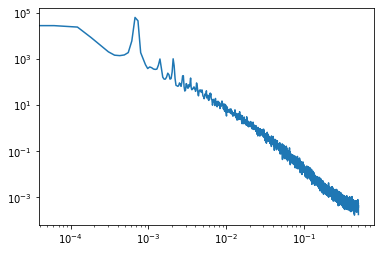

In [12]:
ff_w, Pxx_w = myWelch(data_summer[0].temperature, noverlap='50%')
plt.figure
plt.loglog(ff_w, Pxx_w)
plt.show()

### For Temperature

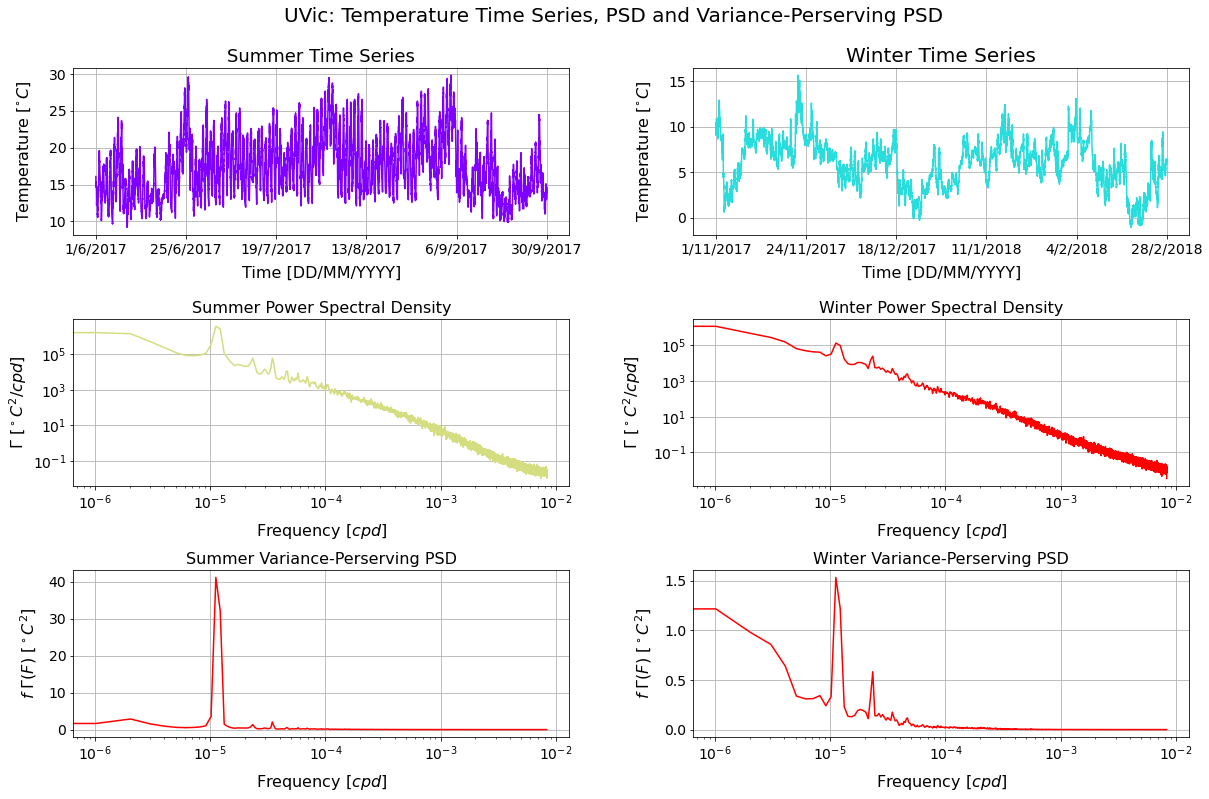

In [ ]:
N = len(data_summer)
for i in range(1):
    plotTemp_withPSD(i, label_names)
    # plt.savefig(station_folders[i] + station_names[i] + "_temp_withPSD.jpeg")
    # plt.close()

### For Pressure

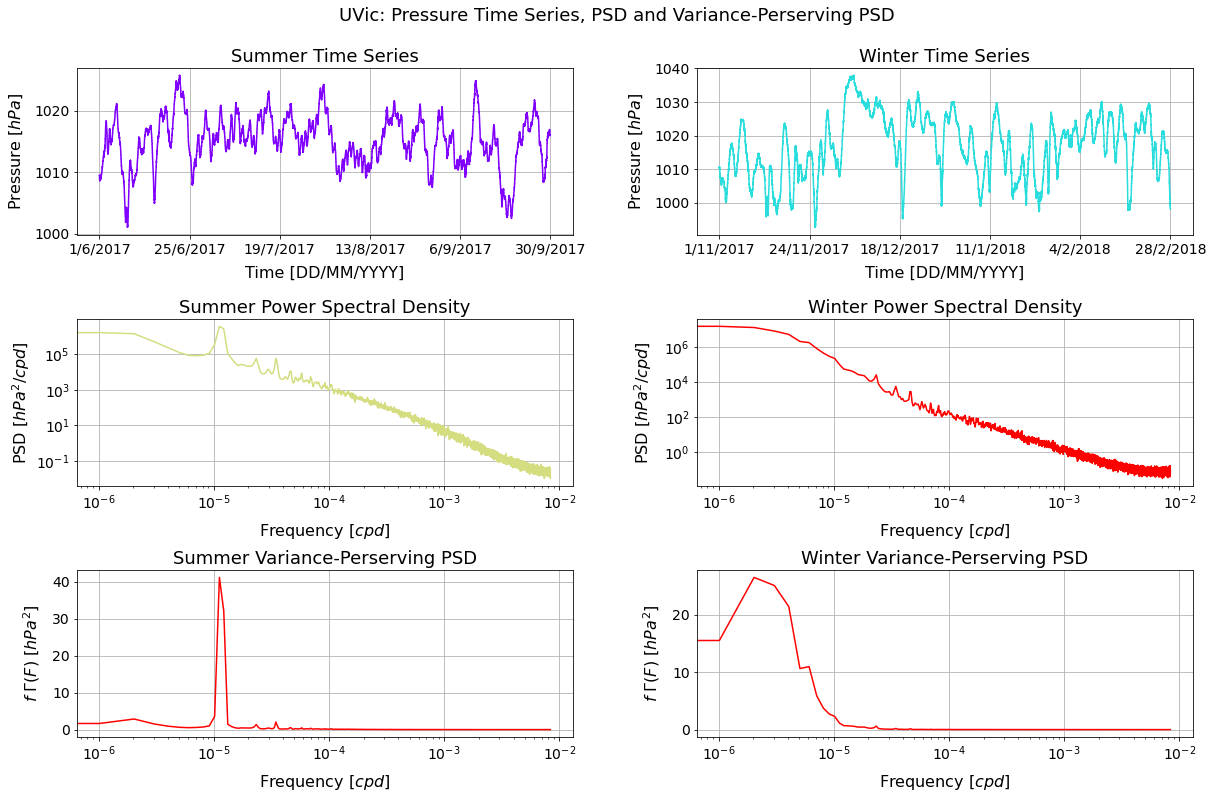

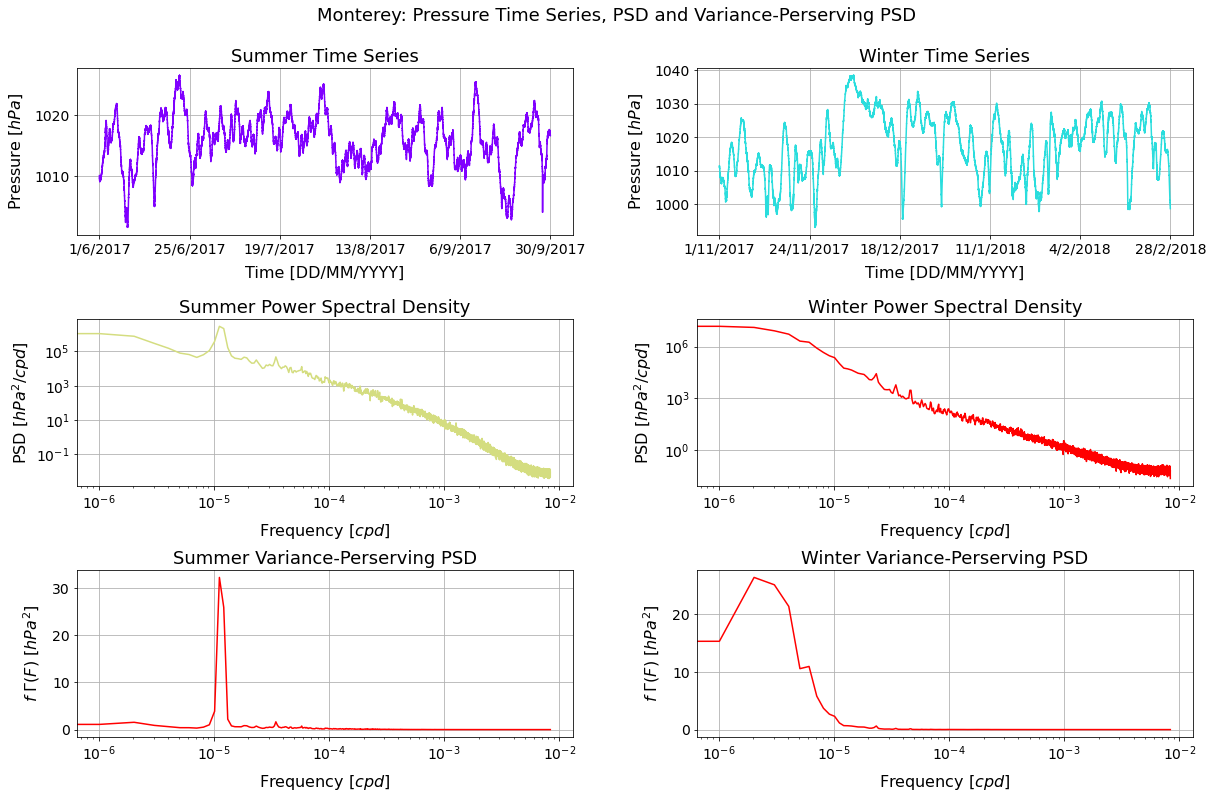

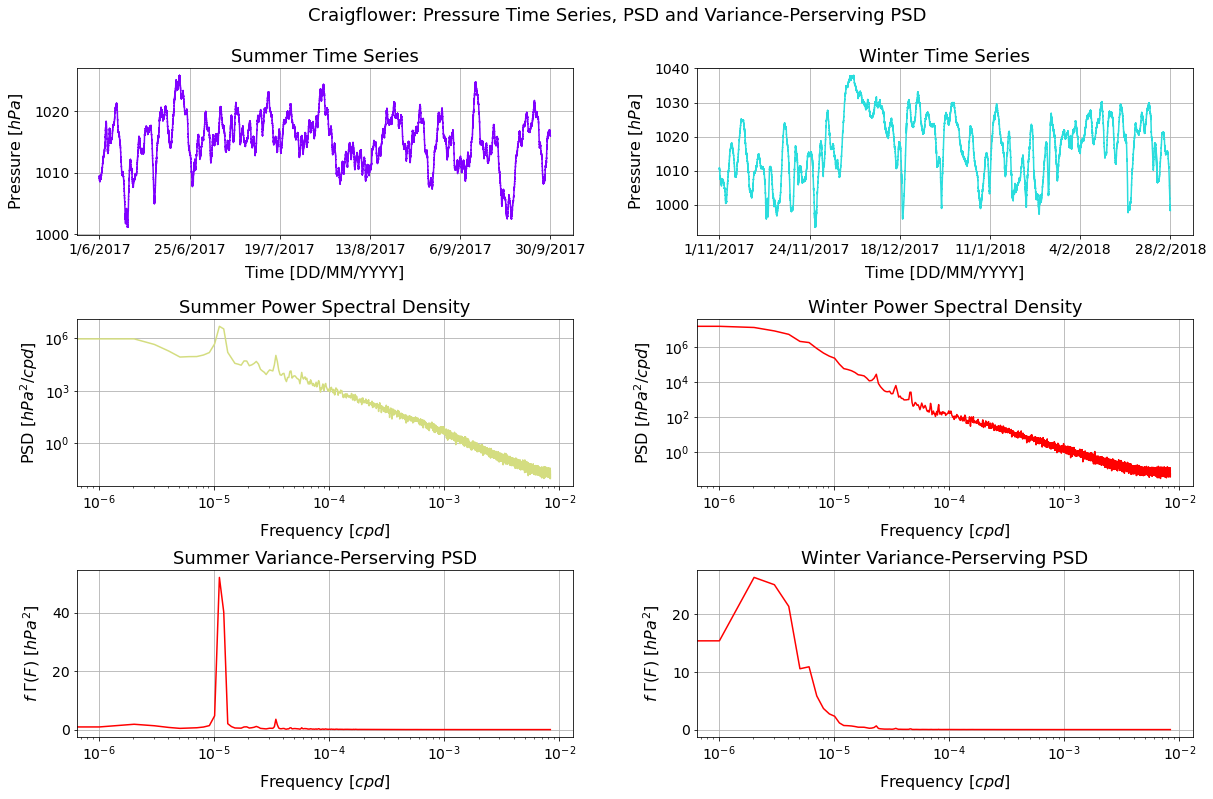

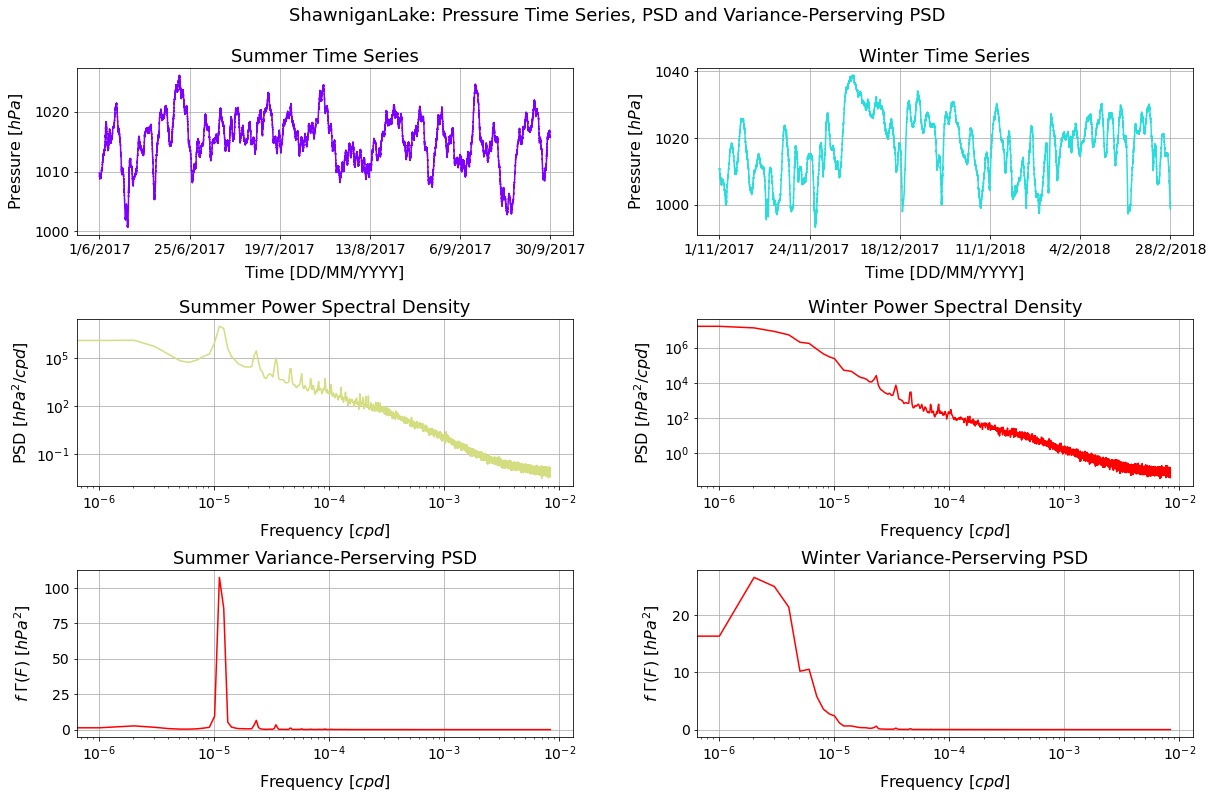

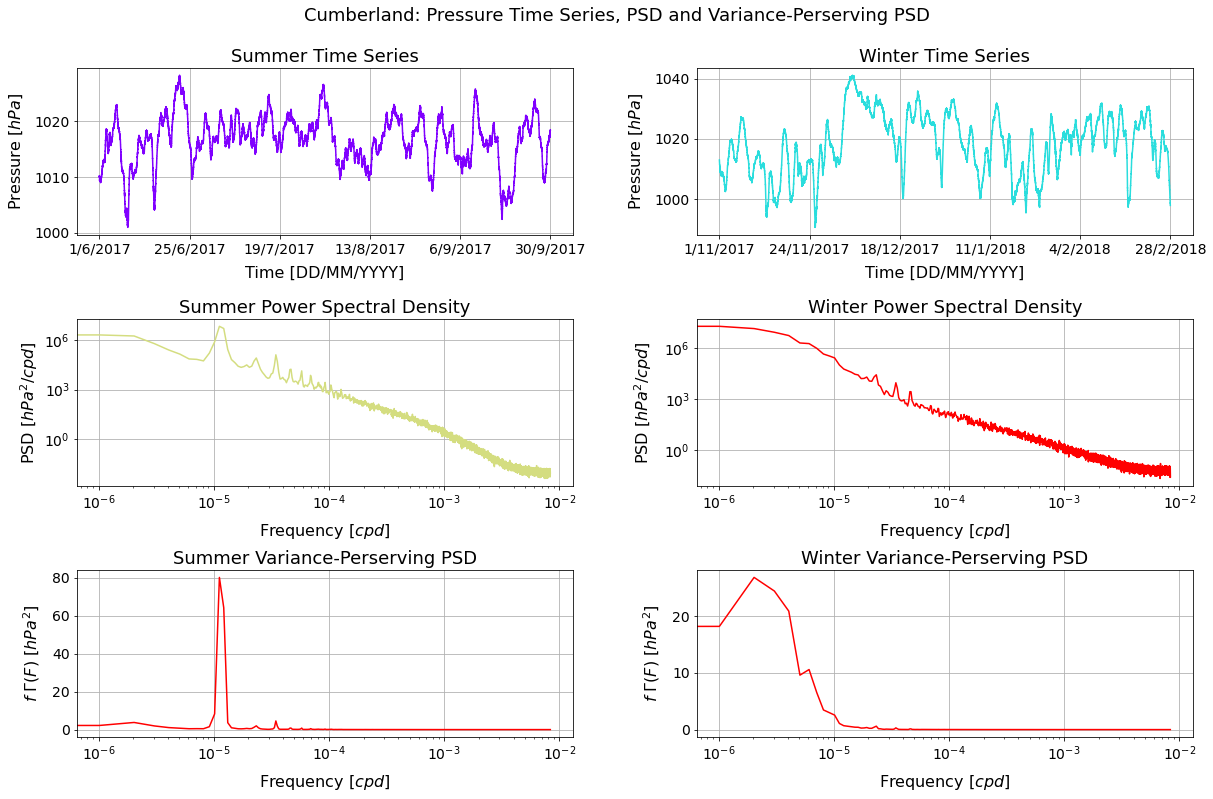

In [ ]:
for i in range(N):
    plotPress_withPSD(i, label_names)
    # plt.savefig(station_folders[i] + station_names[i] + "_press_withPSD.jpeg")
    # plt.close()

## Making PDF histograms

In [ ]:
def makeTempHistograms(data, title = ""):

    xlabel = "Temperature [$^\circ C$]"
    fs = 12 # fontsize = 12

    summer_data, winter_data = data
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title,  y=.99, fontsize=18)
    fig.supylabel("Normalized Counts", fontsize = fs+3, x=0.01)


    axes = np.hstack(axes)
    bins = 50

    axs = axes[0]
    tmp = summer_data.temperature
    axs.hist(tmp, bins=bins, density=True, edgecolor='k')
    xs = np.linspace(min(tmp), max(tmp), 1000)
    axs.plot(xs, sp_stats.norm.pdf(xs, np.nanmean(tmp), np.nanstd(tmp)), label='PDF', linewidth=2)
    axs.set_title("Histogram of Summer", fontsize = fs+2)
    axs.set_xlabel(xlabel, fontsize = fs)
    axs.legend()


    axs = axes[1]
    tmp = winter_data.temperature
    axs.hist(tmp, bins=bins, density=True, edgecolor='k')
    xs = np.linspace(min(tmp), max(tmp), 1000)
    axs.plot(xs, sp_stats.norm.pdf(xs, np.nanmean(tmp), np.nanstd(tmp)), label="PDF", linewidth=2)
    axs.set_title("Histogram of Winter", fontsize = fs+2)
    axs.set_xlabel(xlabel, fontsize = fs)
    axs.legend()

    fig.tight_layout(w_pad=3)

def makePressHistograms(data, title = ""):

    xlabel = "Pressure [$hPa$]"
    fs = 12 # fontsize = 12

    summer_data, winter_data = data
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title,  y=.99, fontsize=18)
    fig.supylabel("Normalized Counts", fontsize = fs+3, x=0)


    axes = np.hstack(axes)
    bins = 50

    axs = axes[0]
    tmp = summer_data.pressure
    axs.hist(tmp, bins=bins, density=True, edgecolor='k')
    xs = np.linspace(min(tmp), max(tmp), 1000)
    axs.plot(xs, sp_stats.norm.pdf(xs, np.nanmean(tmp), np.nanstd(tmp)), label='PDF', linewidth=2)
    axs.set_title("Histogram of Summer", fontsize = fs+2)
    axs.set_xlabel(xlabel, fontsize = fs)
    axs.legend()


    axs = axes[1]
    tmp = winter_data.pressure
    axs.hist(tmp, bins=bins, density=True, edgecolor='k')
    xs = np.linspace(min(tmp), max(tmp), 1000)
    axs.plot(xs, sp_stats.norm.pdf(xs, np.nanmean(tmp), np.nanstd(tmp)), label="PDF", linewidth=2)
    axs.set_title("Histogram of Winter", fontsize = fs+2)
    axs.set_xlabel(xlabel, fontsize = fs)
    axs.legend()

    fig.tight_layout(w_pad=3)

### For Temperature

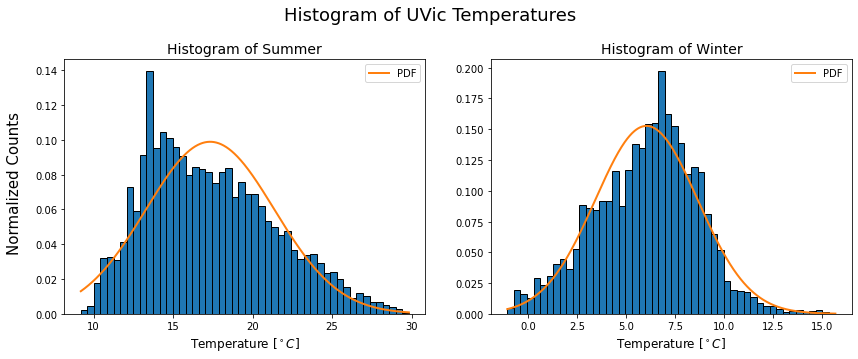

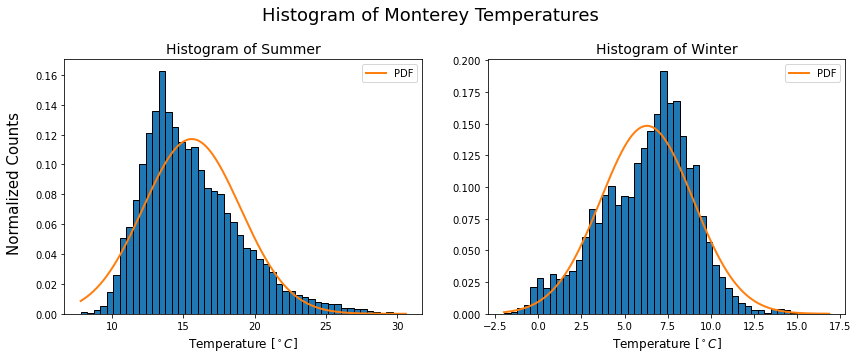

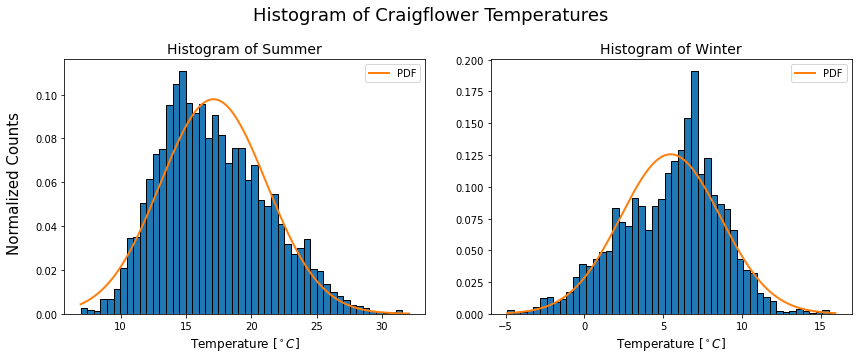

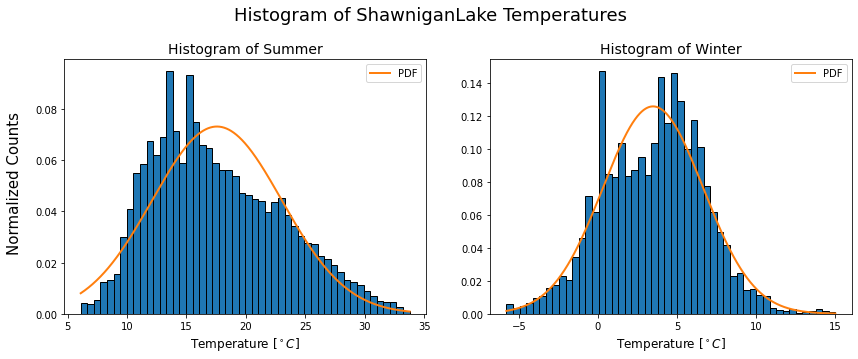

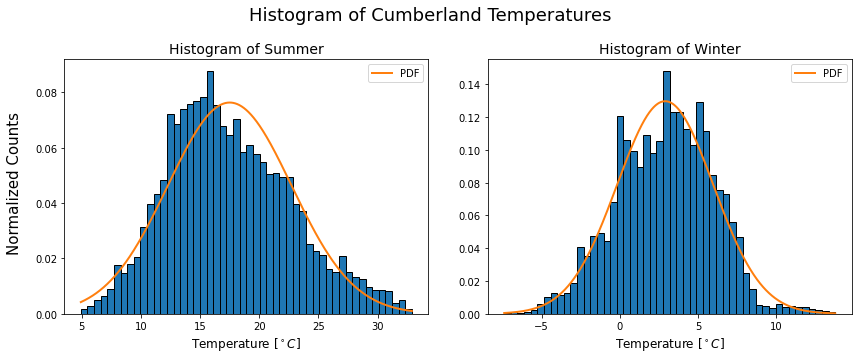

In [ ]:
N = len(data_summer)
for i in range(N):
    title = f'Histogram of {label_names[i]} Temperatures'
    tmp = [data_summer[i], data_winter[i]]
    makeTempHistograms(tmp, title=title)
    # plt.savefig(station_folders[i] + station_names[i] + "_Temp_Histogram.jpeg")
    # plt.close()

### For Pressure

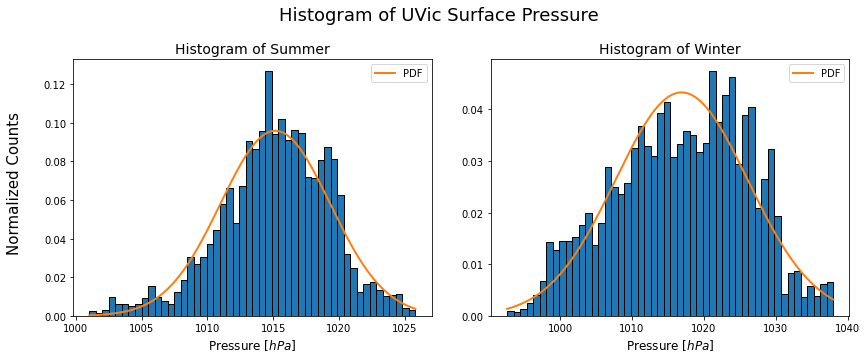

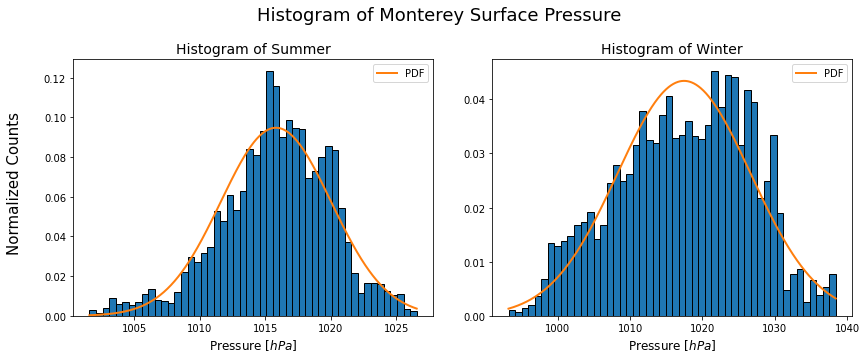

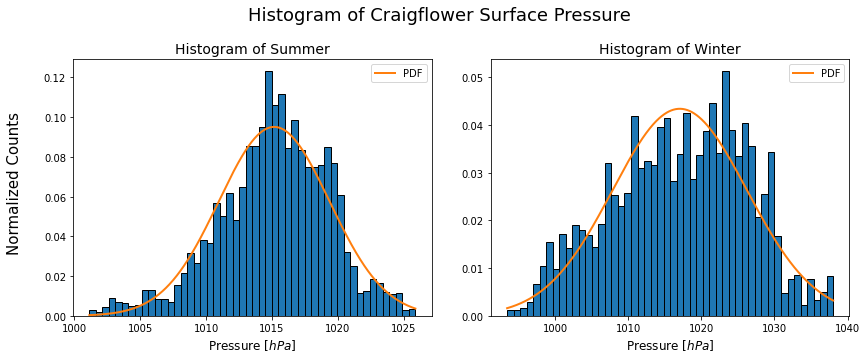

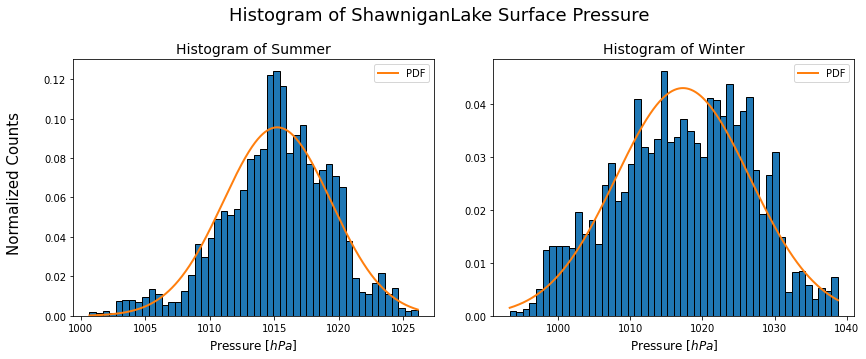

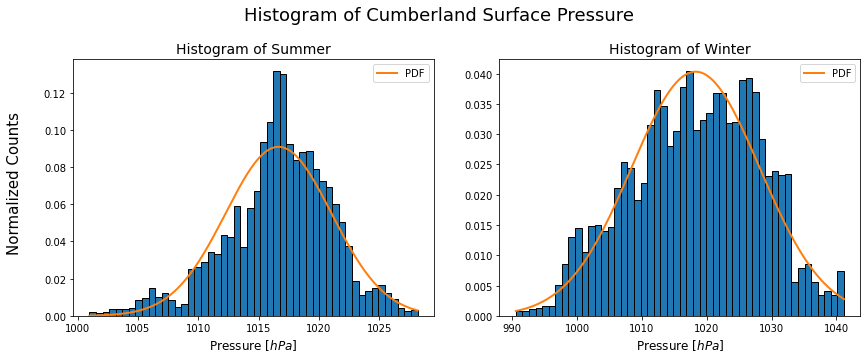

In [ ]:
for i in range(N):
    title = f'Histogram of {label_names[i]} Surface Pressure'
    tmp = [data_summer[i], data_winter[i]]
    makePressHistograms(tmp, title=title)
    # plt.savefig(station_folders[i] + station_names[i] + "_Press_Histogram.jpeg")
    # plt.close()

## Making seaborn heatmap to see Cross-Correlation

In [ ]:
def makeCrossCorrPlot(data, title=''):    
    
    summer = pd.DataFrame(data[0], index=abbr_names).T
    winter = pd.DataFrame(data[1], index=abbr_names).T

    fs = 14 # fontsize 
    fig, axes = plt.subplots(2, 1, figsize=(13, 10))
    fig.suptitle(title,  y=.99, fontsize=fs+4)
    axes = np.hstack(axes)
    
    # For summer data
    axs = axes[0]
    corr = summer.corr()
    ax = sb.heatmap(corr, annot=True, cmap='plasma', ax=axs, fmt=".2f")
    axs.set_title("Summer Correlation", fontsize=fs+2)
    axs.tick_params(labelsize=fs)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fs-2)

    # For winter data
    axs = axes[1]
    corr = winter.corr()
    ax = sb.heatmap(corr, annot=True, cmap='plasma', ax=axs, fmt=".2f")
    axs.set_title("Winter Correlation", fontsize=fs+2)
    axs.tick_params(labelsize=fs)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fs-2)
    fig.tight_layout(h_pad=4)

In [ ]:
tmp = data_summer
times_summer = np.hstack([tmp[i].times for i in range(len(tmp))])
temp_summer = np.array([tmp[i].temperature for i in range(len(tmp))])
press_summer = np.array([tmp[i].pressure for i in range(len(tmp))])

tmp = data_winter
times_winter = np.hstack([tmp[i].times for i in range(len(tmp))])
temp_winter = np.array([tmp[i].temperature for i in range(len(tmp))])
press_winter = np.array([tmp[i].pressure for i in range(len(tmp))])

### For Temperature

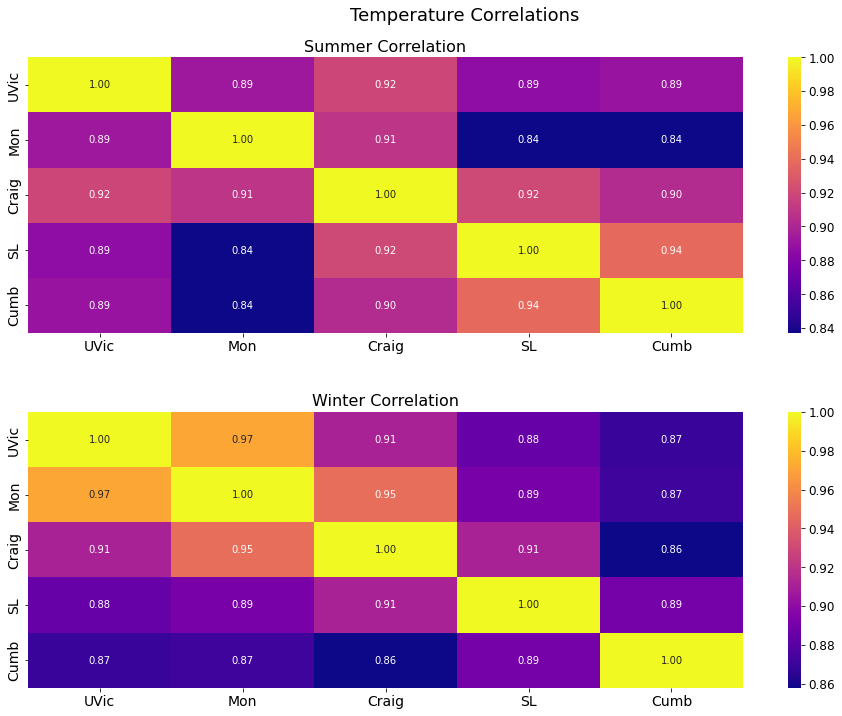

In [ ]:
title = 'Temperature Correlations'

d = [temp_summer, temp_winter]
makeCrossCorrPlot(d, title=title)
# plt.savefig(corr_folder +  "Temperature.jpeg")
# plt.close()


### For Pressure

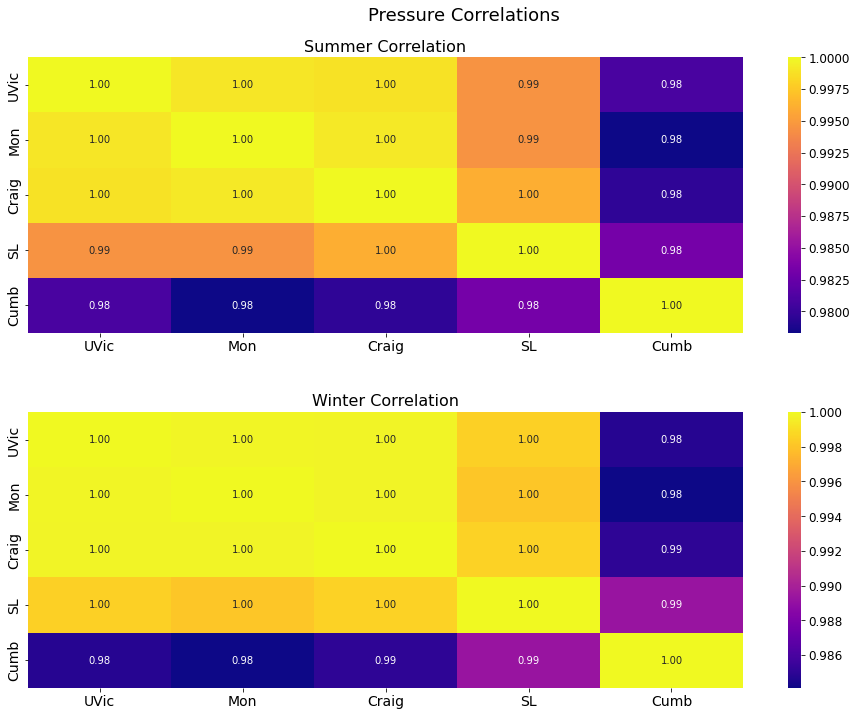

In [ ]:
title = 'Pressure Correlations'

d = [press_summer, press_winter]
makeCrossCorrPlot(d, title=title)
# plt.savefig(corr_folder +  "Pressure.jpeg")
# plt.close()
